# Inception

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Input, Conv2D, BatchNormalization, Concatenate, MaxPool2D, AveragePooling2D, \
                                    Flatten, Dense
from tensorflow.keras.activations import relu
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy

In [2]:
tf.keras.backend.clear_session()

## Data

In [3]:
# load the data in train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [4]:
# normalizing the images
x_train = x_train/255
x_test = x_test/255

# onehot encode the target
y_train = tf.one_hot(y_train, 10, dtype='int8')
y_test = tf.one_hot(y_test, 10, dtype='int8')

# removing the excesive dimension
y_train = tf.reshape(y_train, (y_train.shape[0], 10))
y_test = tf.reshape(y_test, (y_test.shape[0], 10))

In [5]:
# check the shapes
print(f"x_train.shape = {x_train.shape}, y_train.shape = {y_train.shape}")
print(f"x_test.shape = {x_test.shape}, y_test.shape = {y_test.shape}")

x_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 10)
x_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 10)


In [6]:
# set the batch size
BATCH_SIZE = 32

# make batches
train = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .shuffle(50000) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)
    
test = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .shuffle(10000) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)

In [7]:
# some global variables
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10

## Model Architecture

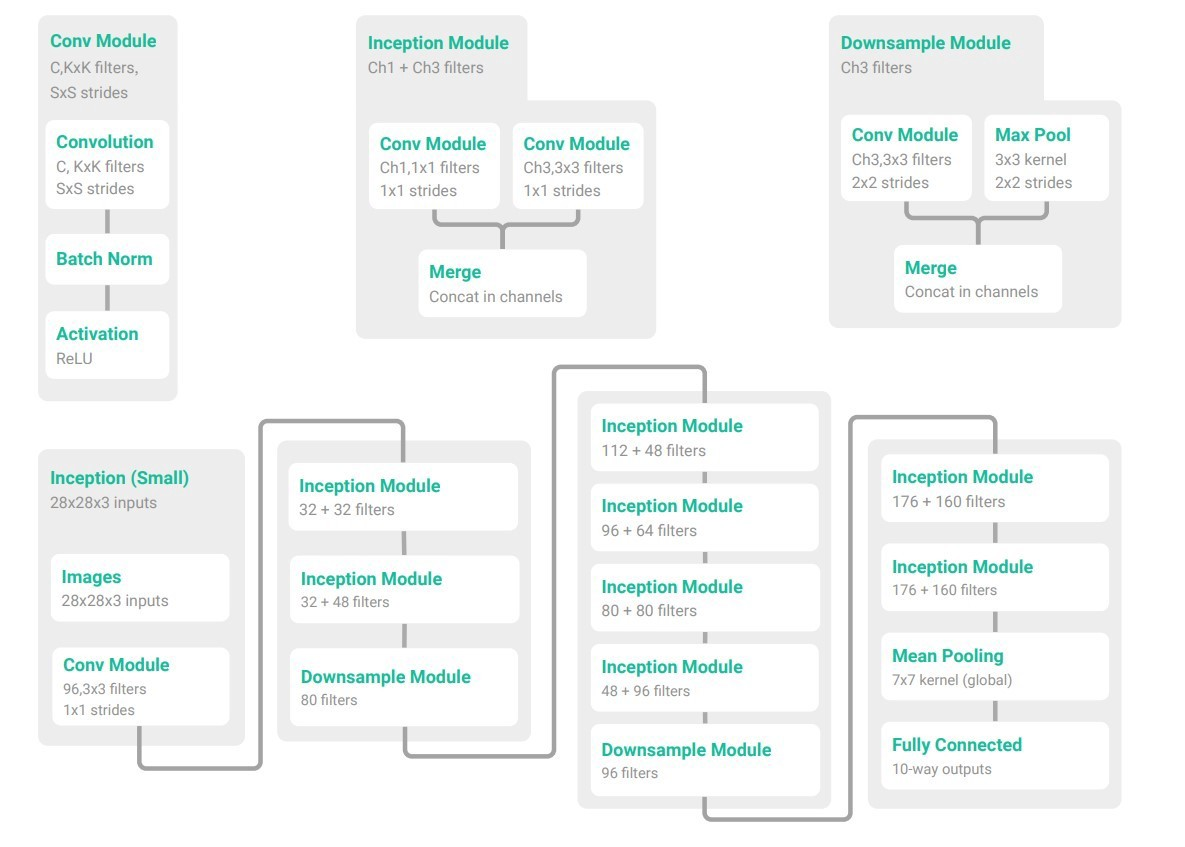

#### Conv Module

In [8]:
class ConvModule(Layer):
    def __init__(self, filters, kernel_size, strides=(1, 1), padding='same'):
        super(ConvModule, self).__init__()
        
        # convolution layer
        self.conv = Conv2D(filters=filters,
                           kernel_size=kernel_size,
                           strides=strides,
                           padding=padding)
        
        # bn layer
        self.bn = BatchNormalization()
        
    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.bn(x, training=False)
        output = relu(x)
        
        return output

#### Inception Module

In [9]:
class InceptionModule(Layer):
    def __init__(self, kernel_size_1x1, kernel_size_3x3):
        super(InceptionModule, self).__init__()
        
        self.conv1 = ConvModule(filters=kernel_size_1x1, kernel_size=1)
        self.conv2 = ConvModule(filters=kernel_size_1x1, kernel_size=3)
        self.concat = Concatenate()
    
    def call(self, input_tensor, training=False):
        x_1x1 = self.conv1(input_tensor)
        x_3x3 = self.conv2(input_tensor)
        output = self.concat([x_1x1, x_3x3])
        
        return output

#### Downsample Module

In [10]:
class DownSampleModule(Layer):
    def __init__(self, filters, padding):
        super(DownSampleModule, self).__init__()
        self.conv3 = ConvModule(filters=filters, kernel_size=(3, 3), strides=(2, 2), padding=padding)
        self.max1 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding=padding)
        self.concat = Concatenate()
    
    def call(self, input_tensor, training=False):
        x_conv = self.conv3(input_tensor)
        x_max = self.max1(input_tensor)
        output = self.concat([x_conv, x_max])
        
        return output

In [11]:
class Inception(Model):
    def __init__(self, num_classes):
        super(Inception, self).__init__()
        
        self.conv1 = ConvModule(96, kernel_size=(3,3))
        self.inc1 = InceptionModule(32, 32)
        self.inc2 = InceptionModule(32, 48)
        self.ds1 = DownSampleModule(80, padding='same')
        
        self.inc3 = InceptionModule(112, 48)
        self.inc4 = InceptionModule(96, 64)
        self.inc5 = InceptionModule(80, 80)
        self.inc6 = InceptionModule(48, 96)
        self.ds2 = DownSampleModule(96, padding='same')
        
        self.inc7 = InceptionModule(176, 160)
        self.inc8 = InceptionModule(176, 160)
        
        self.mean = AveragePooling2D(pool_size=(7, 7))
        self.flat = Flatten()
        self.dense = Dense(num_classes, activation='softmax')
    
    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.inc1(x)
        x = self.inc2(x)
        x = self.ds1(x)
        
        x = self.inc3(x)
        x = self.inc4(x)
        x = self.inc5(x)
        x = self.inc6(x)
        x = self.ds2(x)
        
        x = self.inc7(x)
        x = self.inc8(x)
        
        x = self.mean(x)
        x = self.flat(x)
        
        output = self.dense(x)
#         output = tf.reshape(self.dense(x), (self.dense(x).shape[0], 10))
#         print(output)
        
        return output  # as_int????
    
    def summary(self, input_shape=INPUT_SHAPE):
        '''
        This method makes the command "model.summary()" work.
        input_shape: (H,W,C), do not specify batch B
        '''
        x = tf.keras.layers.Input(shape=input_shape)
        model = tf.keras.Model(inputs=[x], outputs=self.call(x), name='Inception')
        print(model.summary())
        return model

In [13]:
model = Inception(NUM_CLASSES)
model.summary()
model.compile(optimizer='Adam', loss=categorical_crossentropy, metrics="accuracy")

Model: "Inception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv_module (ConvModule)    (None, 32, 32, 96)        3072      
                                                                 
 inception_module (Inception  (None, 32, 32, 64)       31040     
 Module)                                                         
                                                                 
 inception_module_1 (Incepti  (None, 32, 32, 64)       20800     
 onModule)                                                       
                                                                 
 down_sample_module (DownSam  (None, 16, 16, 144)      46480     
 pleModule)                                                      
                                                         

In [15]:
model.fit(train, batch_size=BATCH_SIZE, epochs=2)

Epoch 1/2
1563/1563 [==============================] - 49s 31ms/step - loss: 0.1289 - accuracy: 0.9551
Epoch 2/2
1563/1563 [==============================] - 49s 31ms/step - loss: 0.1229 - accuracy: 0.9573


In [16]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.9658 - accuracy: 0.7806


[0.965813398361206, 0.7806000113487244]

#### Sources:

https://towardsdatascience.com/model-sub-classing-and-custom-training-loop-from-scratch-in-tensorflow-2-cc1d4f10fb4e